# set up

In [1]:
# %mkdir /kaggle/working/dataset
# %mkdir /kaggle/working/dataset/tokenizer
# %mkdir /kaggle/working/dataset/statistic

In [2]:
# !git clone https://github.com/pnthi1604/nlp_data_processing

In [3]:
# !pip install contractions
# !pip install bs4
# !pip install underthesea

# import

In [4]:
from utils.mapping import (
    separate_text,
    separate_word,
    normalize_punctuation_spacing,
    contraction,
    word_tokenize_vn,
    separate_text_with_min_max_len,
)

from utils.statistic import (
    draw_graph,
    draw_hist_graph,
    get_length_tokens,
)

from utils.save import (
    write_file,
)

from utils.filter import (
    condition_length_with_tokenizer,
    condition_non_number_character,
    condition_min_max_length,
)

from utils.tokenizers import (
    ApiTokenizerHuggingFace,
    read_tokenizer,
    BPE_TOKEN,
    WORDPIECE_TOKEN,
    WORDLEVEL_TOKEN,
)

from utils.seed import set_seed

from utils.create_noise import (
    token_masking,
    token_deletion,
    document_rotation,
    text_infilling,
    sentence_permutation,
    TOKEN_MASKING,
    TOKEN_DELETION,
    DOCUMENT_ROTATION,
    TEXT_INFILLING,
    SENTENCE_PERMUTATION,
)

import pandas as pd
import torch

In [5]:
text = "hi my name is and i am years old. i am from and i am a. i am a. asfda asf as SRFQW DSV."
separate_text_with_min_max_len(text, 0, 12)

['hi my name is and i am years old.',
 'i am from and i am a. i am a.',
 'asfda asf as SRFQW DSV.']

# seed

In [6]:
set_seed(seed=42)

# config

In [7]:
config = {}
GET_NOISE_FN = {
    TOKEN_MASKING: token_masking,
    TOKEN_DELETION: token_deletion,
    DOCUMENT_ROTATION: document_rotation,
    TEXT_INFILLING: text_infilling,
    SENTENCE_PERMUTATION: sentence_permutation,
}


config["max_sample"] = 10000
config["max_get_sample"] = 10000

config["raw_data_path"] = "./dataset/bart/pretrain/raw_data/dataset.csv"
config["train_data_path"] = "./dataset/bart/pretrain/delete/train.csv"

config["min_len_token"] = 9
config["max_len_token"] = 400
config["ranges"] = [(9, 100, 0.1), (100, 200, 0.4), (201, 400, 0.6)] # (min, max, ratio)

config["lang_src"] = "noise_vi"
config["lang_tgt"] = "vi"

config["vocab_size_src"] = 30000
config["vocab_size_tgt"] = 30000
config["min_frequency"] = 2
config["special_tokens"] = [
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
    "<cls>",
    "<sep>",
]
config["type_token_src"] = WORDPIECE_TOKEN
config["type_token_tgt"] = WORDPIECE_TOKEN
# TOKEN_MASKING
# TOKEN_DELETION
# DOCUMENT_ROTATION
# TEXT_INFILLING
# SENTENCE_PERMUTATION
config["type_noise"] = TEXT_INFILLING
config["ratio"] = 0.2

config["tokenizer_src_path"] = "./dataset/bart/pretrain/delete/tokenizer_src.json"
config["tokenizer_tgt_path"] = "./dataset/bart/pretrain/delete/tokenizer_tgt.json"

config["graph_len_token_src_path"] = "./dataset/bart/pretrain/delete/len_token_src.png"
config["graph_len_token_tgt_path"] = "./dataset/bart/pretrain/delete/len_token_tgt.png"

config["desc_path"] = "./dataset/bart/pretrain/delete/desc.txt"

# read raw data

In [8]:
raw_data = pd.read_csv(config["raw_data_path"])[:config["max_sample"]]
raw_data = raw_data.dropna()
raw_data = raw_data.drop_duplicates()
raw_data

,URL,Title,Summary,Contents,Date,Author(s),Category,Tags
0,https://laodong.vn/bat-dong-san/thong-tin-ngoc...,"Thông tin “Ngọc Trinh mua đất ở Bảo Lộc"" chỉ l...","Lâm Đồng - Lãnh đạo thành phố Bảo Lộc, Lâm Đồn...","Những ngày vừa qua, trên trang Facebook chính ...","Thứ sáu, 20/05/2022 08:56 (GMT+7)",Phương Nhiên,Bất động sản,"['Lâm Đồng', 'Ngọc Trinh', 'Chiêu trò', 'Giá đ..."
1,https://laodong.vn/bat-dong-san/lo-hong-trong-...,Lỗ hổng trong việc thẩm tra năng lực tài chính...,TPHCM - Việc không thể cưỡng chế thuế của hai ...,"Theo thông tin từ Cục Thuế TP.HCM, hiện cơ qua...","Thứ sáu, 20/05/2022 08:10 (GMT+7)",Gia Miêu,Bất động sản,"['Thủ Thiêm', 'Đấu giá đất']"
2,https://laodong.vn/bat-dong-san/som-hoan-thien...,Sớm hoàn thiện các dự án nhà ở xã hội để CNLĐ ...,"Hiện trên địa bàn tỉnh Ninh Bình có 32 khu, cụ...",CNLĐ mong muốn sớm được tiếp cận với nhà ở xã ...,"Thứ sáu, 20/05/2022 07:47 (GMT+7)",NGUYỄN TRƯỜNG,Bất động sản,"['Dự án', 'Nhà ở xã hội', 'Dự án nhà ở xã hội'..."
3,https://laodong.vn/bat-dong-san/chi-tiet-ho-so...,Chi tiết hồ sơ hoàn công nhà ở năm 2022,Hoàn công nhà ở với ý nghĩa là điều kiện để đư...,Hoàn công nhà ở là một thủ tục hành chính tron...,"Thứ sáu, 20/05/2022 06:44 (GMT+7)",Kim Nhung (T/H),Bất động sản,"['Giấy phép xây dựng', 'Hồ sơ hoàn công', 'nhà..."
4,https://laodong.vn/bat-dong-san/khoi-tao-khong...,"Khởi tạo không gian sống đẳng cấp, đón sóng đầ...",Có rất nhiều lý do khiến những dự án thấp nội ...,Đi dọc đường Lê Văn Lương kéo dài xuống khu Dư...,"Thứ năm, 19/05/2022 15:30 (GMT+7)",Huyền Nguyễn,Bất động sản,['An Quý Villa']
...,...,...,...,...,...,...,...,...
9995,https://laodong.vn/thoi-su/trao-quyet-dinh-bo-...,Trao quyết định bổ nhiệm Tổng Giám đốc Đài Tiế...,Trao quyết định bổ nhiệm Tổng Giám đốc Đài Tiế...,Phó Thủ tướng đánh giá ông Đỗ Tiến Sỹ là cán b...,"Thứ tư, 30/06/2021 16:55 (GMT+7)",THEO CHINHPHU.VN,Thời sự,"['Việt Nam', 'Chính phủ', 'Tổng Giám đốc Đài T..."
9996,https://laodong.vn/thoi-su/binh-duong-tap-trun...,"Bình Dương tập trung khoanh gọn, không để dịch...",Phát biểu chỉ đạo tại cuộc họp trực tuyến với ...,Tốc độ lấy mẫu phải đồng bộ với tốc độ xét ngh...,"Thứ tư, 30/06/2021 16:08 (GMT+7)",THEO TTXVN,Thời sự,"['Phó Thủ tướng', 'Bình Dương', 'Điều trị COVI..."
9997,https://laodong.vn/thoi-su/hai-phong-ung-vien-...,Hải Phòng: Ứng viên Phó Chủ tịch Hội đồng quận...,Một ứng viên cho chức danh Phó Chủ tịch Hội đồ...,"Sáng ngày 30.6, kỳ họp thứ nhất HĐND quận Hải ...","Thứ tư, 30/06/2021 16:06 (GMT+7)",Mai Chi,Thời sự,"['Hải Phòng', 'Tin Hải Phòng', 'Bầu cử Hội đồn..."
9998,https://laodong.vn/thoi-su/ong-nguyen-van-son-...,Ông Nguyễn Văn Sơn tái đắc cử Chủ tịch UBND tỉ...,"Ngày 30.6, Hội đồng Nhân dân (HĐND) tỉnh Tuyên...","Với 100% số phiếu đồng ý, ông Nguyễn Văn Sơn, ...","Thứ tư, 30/06/2021 16:04 (GMT+7)",Phong Quang,Thời sự,"['Tái đắc cử', 'Tuyên Quang', 'HĐND', 'Kỳ họp']"


In [9]:
raw_data = raw_data.rename(columns={"Contents": config["lang_src"]})
raw_data = raw_data[[config["lang_src"]]]
raw_data = raw_data.drop_duplicates()
raw_data = raw_data.dropna()
raw_data

,noise_vi
0,"Những ngày vừa qua, trên trang Facebook chính ..."
1,"Theo thông tin từ Cục Thuế TP.HCM, hiện cơ qua..."
2,CNLĐ mong muốn sớm được tiếp cận với nhà ở xã ...
3,Hoàn công nhà ở là một thủ tục hành chính tron...
4,Đi dọc đường Lê Văn Lương kéo dài xuống khu Dư...
...,...
9995,Phó Thủ tướng đánh giá ông Đỗ Tiến Sỹ là cán b...
9996,Tốc độ lấy mẫu phải đồng bộ với tốc độ xét ngh...
9997,"Sáng ngày 30.6, kỳ họp thứ nhất HĐND quận Hải ..."
9998,"Với 100% số phiếu đồng ý, ông Nguyễn Văn Sơn, ..."


# split sentence

In [10]:
new_raw_dataset = None
for min_len, max_len, ratio in config["ranges"]:
    tmp_raw_data = raw_data.copy()
    tmp_raw_data[config["lang_src"]] = tmp_raw_data[config["lang_src"]].apply(lambda text: separate_text_with_min_max_len(
        text=text,
        min_len=min_len,
        max_len=max_len,
    ))
    tmp_raw_data = tmp_raw_data.explode(config["lang_src"])
    max_sample = int(config["max_get_sample"] * ratio)
    tmp_raw_data = tmp_raw_data[:max_sample]
    if new_raw_dataset is None:
        new_raw_dataset = tmp_raw_data
    else:
        new_raw_dataset = pd.concat([new_raw_dataset, tmp_raw_data])

raw_data = new_raw_dataset
raw_data[config["lang_tgt"]] = raw_data[config["lang_src"]]
raw_data.reset_index(drop=True, inplace=True)
raw_data

,noise_vi,vi
0,"Trước thông tin này, ông Đoàn Kim Đình - Chủ t...","Trước thông tin này, ông Đoàn Kim Đình - Chủ t..."
1,Trong các hồ sơ thủ tục liên quan đất đai trên...,Trong các hồ sơ thủ tục liên quan đất đai trên...
2,Đại diện lãnh đạo UBND TP.Bảo Lộc cũng nói thê...,Đại diện lãnh đạo UBND TP.Bảo Lộc cũng nói thê...
3,"Việc này, khiến dư luận đánh giá sai về công t...","Việc này, khiến dư luận đánh giá sai về công t..."
4,"Người dân cũng cần hết sức cẩn thận, kiểm chứn...","Người dân cũng cần hết sức cẩn thận, kiểm chứn..."
...,...,...
10995,"Khu nhà giàu ""rủ nhau"" trả mặt bằng Dạo một v...","Khu nhà giàu ""rủ nhau"" trả mặt bằng Dạo một v..."
10996,với giá thuê giảm hàng chục triệu đồng so với ...,với giá thuê giảm hàng chục triệu đồng so với ...
10997,Một con số được đưa ra tại hội nghị Giải pháp ...,Một con số được đưa ra tại hội nghị Giải pháp ...
10998,Hạ Long thực sự là thỏi nam châm thu hút đầu t...,Hạ Long thực sự là thỏi nam châm thu hút đầu t...


# filter number character

In [11]:
# raw_data = raw_data[raw_data.apply(
#     lambda text: condition_non_number_character(
#         text=text[config["lang_src"]],
#     ) and condition_non_number_character(
#         text=text[config["lang_tgt"]],
#     ),
#     axis=1,
# )]
# raw_data.reset_index(drop=True, inplace=True)
# raw_data = raw_data[:int(config["max_get_sample"] * 1.1)]
# raw_data

# filter number words

In [12]:
raw_data = raw_data[raw_data.apply(
    lambda text: condition_min_max_length(
        text=text[config["lang_src"]],
        min_len=config["min_len_token"],
        max_len=config["max_len_token"],
    ) and condition_min_max_length(
        text=text[config["lang_tgt"]],
        min_len=config["min_len_token"],
        max_len=config["max_len_token"],
    ),
    axis=1,
)]
raw_data.reset_index(drop=True, inplace=True)
raw_data = raw_data[:int(config["max_get_sample"] * 1.1)]
raw_data

,noise_vi,vi
0,"Trước thông tin này, ông Đoàn Kim Đình - Chủ t...","Trước thông tin này, ông Đoàn Kim Đình - Chủ t..."
1,Trong các hồ sơ thủ tục liên quan đất đai trên...,Trong các hồ sơ thủ tục liên quan đất đai trên...
2,Đại diện lãnh đạo UBND TP.Bảo Lộc cũng nói thê...,Đại diện lãnh đạo UBND TP.Bảo Lộc cũng nói thê...
3,"Việc này, khiến dư luận đánh giá sai về công t...","Việc này, khiến dư luận đánh giá sai về công t..."
4,"Người dân cũng cần hết sức cẩn thận, kiểm chứn...","Người dân cũng cần hết sức cẩn thận, kiểm chứn..."
...,...,...
10763,"Khu nhà giàu ""rủ nhau"" trả mặt bằng Dạo một v...","Khu nhà giàu ""rủ nhau"" trả mặt bằng Dạo một v..."
10764,với giá thuê giảm hàng chục triệu đồng so với ...,với giá thuê giảm hàng chục triệu đồng so với ...
10765,Một con số được đưa ra tại hội nghị Giải pháp ...,Một con số được đưa ra tại hội nghị Giải pháp ...
10766,Hạ Long thực sự là thỏi nam châm thu hút đầu t...,Hạ Long thực sự là thỏi nam châm thu hút đầu t...


# normalize data

In [13]:
def mapping_item(item):
    return  normalize_punctuation_spacing(item.lower()).strip()

if config["max_get_sample"] <= 4000000:
    raw_data = pd.concat([raw_data, raw_data], ignore_index=True)
else:  
    raw_data = pd.concat([raw_data, raw_data, raw_data], ignore_index=True)
    
raw_data[config["lang_src"]] = raw_data[config["lang_src"]].map(lambda item: mapping_item(item))
raw_data[config["lang_tgt"]] = raw_data[config["lang_tgt"]].map(lambda item: mapping_item(item))
if config["lang_src"] == "noise_vi":
    noise_fn = GET_NOISE_FN[config["type_noise"]]
    ratio = config["ratio"]
    raw_data[config["lang_src"]] = raw_data[config["lang_src"]].map(lambda item: noise_fn(
        text=item,
        ratio=ratio,
    ))
raw_data

,noise_vi,vi
0,"trước thông tin này , ông đoàn kim đình - chủ ...","trước thông tin này , ông đoàn kim đình - chủ ..."
1,trong các hồ sơ thủ tục liên quan đất đai trên...,trong các hồ sơ thủ tục liên quan đất đai trên...
2,đại diện lãnh <mask> tp . bảo lộc cũng nói thê...,đại diện lãnh đạo ubnd tp . bảo lộc cũng nói t...
3,"việc này , khiến dư <mask> giá sai về công tác...","việc này , khiến dư luận đánh giá sai về công ..."
4,"người dân cũng cần hết sức cẩn thận , kiểm chứ...","người dân cũng cần hết sức cẩn thận , kiểm chứ..."
...,...,...
21531,"khu nhà giàu ""rủ nhau"" trả mặt bằng dạo một vò...","khu nhà giàu ""rủ nhau"" trả mặt bằng dạo một vò..."
21532,với giá thuê giảm hàng chục triệu đồng so với ...,với giá thuê giảm hàng chục triệu đồng so với ...
21533,một con số được đưa ra tại hội nghị giải pháp ...,một con số được đưa ra tại hội nghị giải pháp ...
21534,hạ long thực sự là thỏi nam châm thu hút đầu t...,hạ long thực sự là thỏi nam châm thu hút đầu t...


# build tokenizer for dataset

In [14]:
dataset = raw_data[[config["lang_src"], config["lang_tgt"]]]
dataset = dataset.drop_duplicates()
dataset = dataset.dropna()
dataset.reset_index(drop=True, inplace=True)
dataset

,noise_vi,vi
0,"trước thông tin này , ông đoàn kim đình - chủ ...","trước thông tin này , ông đoàn kim đình - chủ ..."
1,trong các hồ sơ thủ tục liên quan đất đai trên...,trong các hồ sơ thủ tục liên quan đất đai trên...
2,đại diện lãnh <mask> tp . bảo lộc cũng nói thê...,đại diện lãnh đạo ubnd tp . bảo lộc cũng nói t...
3,"việc này , khiến dư <mask> giá sai về công tác...","việc này , khiến dư luận đánh giá sai về công ..."
4,"người dân cũng cần hết sức cẩn thận , kiểm chứ...","người dân cũng cần hết sức cẩn thận , kiểm chứ..."
...,...,...
21531,"khu nhà giàu ""rủ nhau"" trả mặt bằng dạo một vò...","khu nhà giàu ""rủ nhau"" trả mặt bằng dạo một vò..."
21532,với giá thuê giảm hàng chục triệu đồng so với ...,với giá thuê giảm hàng chục triệu đồng so với ...
21533,một con số được đưa ra tại hội nghị giải pháp ...,một con số được đưa ra tại hội nghị giải pháp ...
21534,hạ long thực sự là thỏi nam châm thu hút đầu t...,hạ long thực sự là thỏi nam châm thu hút đầu t...


In [15]:
trainer_tokenizer_src = ApiTokenizerHuggingFace(
    dataset=dataset[config["lang_src"]],
    vocab_size=config["vocab_size_src"],
    min_frequency=config["min_frequency"],
    special_tokens=config["special_tokens"],
    type_token=config["type_token_src"],
)

trainer_tokenizer_tgt = ApiTokenizerHuggingFace(
    dataset=dataset[config["lang_tgt"]],
    vocab_size=config["vocab_size_tgt"],
    min_frequency=config["min_frequency"],
    special_tokens=config["special_tokens"],
    type_token=config["type_token_tgt"],
)

In [16]:
# train tokenizer
tokenzier_src = trainer_tokenizer_src.train()
tokenzier_tgt = trainer_tokenizer_tgt.train()

# save tokenizer
tokenzier_src.save(config["tokenizer_src_path"])
tokenzier_tgt.save(config["tokenizer_tgt_path"])

# read tokenizer
tokenizer_src, tokenizer_tgt = read_tokenizer(
    tokenizer_src_path=config["tokenizer_src_path"],
    tokenizer_tgt_path=config["tokenizer_tgt_path"],
)

config["vocab_size_src"] = tokenzier_src.get_vocab_size()
config["vocab_size_tgt"] = tokenzier_tgt.get_vocab_size()

print("Vocab size src: ", config["vocab_size_src"])
print("Vocab size tgt: ", config["vocab_size_tgt"])







Vocab size src:  14103
Vocab size tgt:  14382


# fillter length tokens

In [17]:
dataset = dataset[dataset.apply(
    lambda text: condition_length_with_tokenizer(
        tokenizer=tokenizer_src,
        text=text[config["lang_src"]],
        min_len_token=config["min_len_token"],
        max_len_token=config["max_len_token"],
    ) and condition_length_with_tokenizer(
        tokenizer=tokenizer_tgt,
        text=text[config["lang_tgt"]],
        min_len_token=config["min_len_token"],
        max_len_token=config["max_len_token"],
    ),
    axis=1,
)]

dataset = dataset[:config["max_get_sample"]]
dataset.reset_index(drop=True, inplace=True)

# save dataset
dataset.to_csv(config["train_data_path"], index=False)

# read dataset
dataset = pd.read_csv(config["train_data_path"])

In [18]:
dataset[config["lang_src"]][0], dataset[config["lang_tgt"]][0]

('trước thông tin này , ông đoàn kim đình - chủ tịch ubnd thành phố <mask> , ubnd thành phố đã <mask> cầu cơ quan chức năng và ubnd xã đại lào phối hợp kiểm chứng thông tin . qua xác minh , khu đất ngọc trinh chụp hình và đăng tải lên mạng xã hội thuộc hẻm 61 b’lao srê , xã đại lào . nhưng đây không phải <mask> dựng homestay của ngọc trinh <mask> <mask>',
 'trước\xa0thông tin này , ông đoàn kim đình - chủ tịch ubnd thành phố bảo lộc cho\xa0biết , ubnd thành phố đã yêu cầu cơ quan chức năng và ubnd xã đại lào phối hợp kiểm chứng thông tin . qua xác minh , khu đất ngọc trinh chụp hình và\xa0đăng tải lên mạng xã hội\xa0thuộc hẻm 61 b’lao srê , xã đại lào . nhưng đây không phải là đất xây dựng homestay của ngọc trinh .')

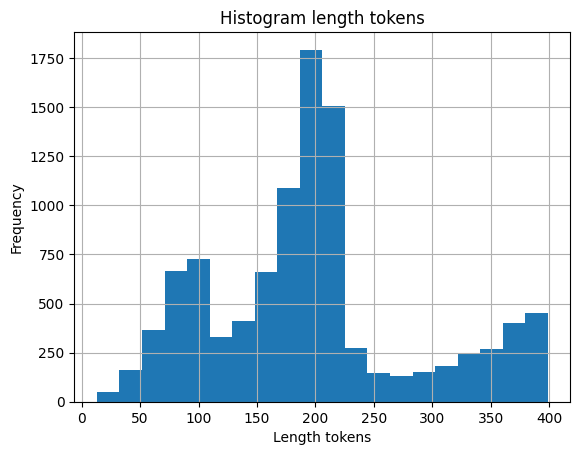

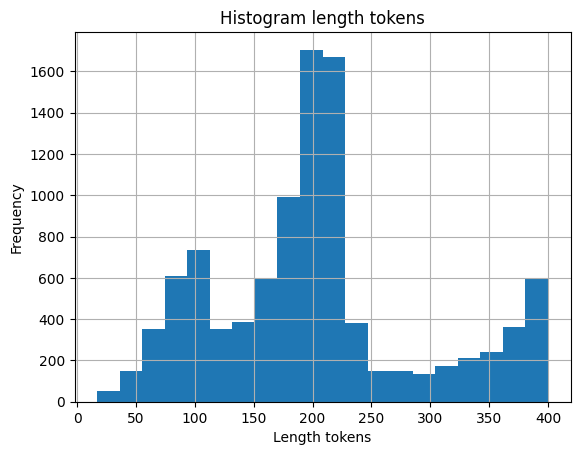

In [19]:
lenght_data_src = get_length_tokens(
    tokenizer=tokenizer_src,
    dataset=dataset[config["lang_src"]],
)

lenght_data_tgt = get_length_tokens(
    tokenizer=tokenizer_tgt,
    dataset=dataset[config["lang_tgt"]],
)

config["min_len_token"] = min(lenght_data_src + lenght_data_tgt)
config["max_len_token"] = max(lenght_data_src + lenght_data_tgt)

draw_hist_graph(
    title="Histogram length tokens",
    xlabel="Length tokens",
    ylabel="Frequency",
    data=lenght_data_src,
    save_path=config["graph_len_token_src_path"],
)
draw_hist_graph(
    title="Histogram length tokens",
    xlabel="Length tokens",
    ylabel="Frequency",
    data=lenght_data_tgt,
    save_path=config["graph_len_token_tgt_path"],
)

# save desc

In [20]:
config["length_dataset"] = len(dataset)
config["desc"] = f"Vocab size src: {config['vocab_size_src']}\nVocab size tgt: {config['vocab_size_tgt']}\nMin frequency: {config['min_frequency']}\nMin len token: {config['min_len_token']}\nMax len token: {config['max_len_token']}\nType token src: {config['type_token_src']}\nType token tgt: {config['type_token_tgt']}\nSpecial tokens: {config['special_tokens']}\nLength dataset: {config['length_dataset']}\nType nosie: {config['type_noise']}\nRatio: {config['ratio']}\nRanges: {config['ranges']}"
write_file(
    file_name=config["desc_path"],
    content=config["desc"],
)